In [56]:
import tensorflow as tf
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Data Loading with Normalization to [-1, 1]
class FontDataset(tf.data.Dataset):
    def __new__(cls, source_dir, target_dir):
        source_images = sorted([os.path.join(source_dir, fname) for fname in os.listdir(source_dir) if not fname.startswith('.')])
        target_images = sorted([os.path.join(target_dir, fname) for fname in os.listdir(target_dir) if not fname.startswith('.')])
        
        def generator():
            for source_image_path, target_image_path in zip(source_images, target_images):
                source_image = np.array(Image.open(source_image_path).convert('L')) / 127.5 - 1
                target_image = np.array(Image.open(target_image_path).convert('L')) / 127.5 - 1
                yield source_image[..., np.newaxis], target_image[..., np.newaxis]

        dataset = tf.data.Dataset.from_generator(generator, output_signature=(
            tf.TensorSpec(shape=(256, 4096, 1), dtype=tf.float32),
            tf.TensorSpec(shape=(256, 4096, 1), dtype=tf.float32)
        ))
        return dataset.batch(1)

# Folders for source and target images
train_source_folder = 'Resized_Text_Train_Images'  # Computer font images
train_target_folder = '/local_dir/Resized_Train_Images'  # Lhasa Kanjur font images
test_source_folder = '/Resized_Text_Test_Images'  # Computer font images
test_target_folder = '/local_dir/Resized_Test_Images'  # Lhasa Kanjur font images

train_dataset = FontDataset(train_source_folder, train_target_folder)
test_dataset = FontDataset(test_source_folder, test_target_folder)

# Display Examples
def display_examples(dataset, title):
    plt.figure(figsize=(10, 10))
    for i, (source, target) in enumerate(dataset.take(5)):
        plt.subplot(5, 2, 2 * i + 1)
        plt.imshow(tf.squeeze(source).numpy(), cmap='gray')
        plt.title(f"{title} Source Image {i+1}")
        plt.axis('off')
        
        plt.subplot(5, 2, 2 * i + 2)
        plt.imshow(tf.squeeze(target).numpy(), cmap='gray')
        plt.title(f"{title} Target Image {i+1}")
        plt.axis('off')
    plt.show()


#display_examples(train_dataset, "Train")
#display_examples(test_dataset, "Test")


In [57]:
from tensorflow.keras import layers

def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(
        layers.Conv2D(filters, size, strides=2, padding='same',
                      kernel_initializer=initializer, use_bias=False))

    if apply_batchnorm:
        result.add(layers.BatchNormalization())

    result.add(layers.LeakyReLU())

    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(
        layers.Conv2DTranspose(filters, size, strides=2,
                               padding='same',
                               kernel_initializer=initializer,
                               use_bias=False))

    result.add(layers.BatchNormalization())

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

def Generator():
    inputs = layers.Input(shape=[256, 4096, 1])

    down_stack = [
        downsample(64, 4, apply_batchnorm=False),  # (bs, 128, 2048, 64)
        downsample(128, 4),  # (bs, 64, 1024, 128)
        downsample(256, 4),  # (bs, 32, 512, 256)
        downsample(512, 4),  # (bs, 16, 256, 512)
        downsample(512, 4),  # (bs, 8, 128, 512)
        downsample(512, 4),  # (bs, 4, 64, 512)
        downsample(512, 4),  # (bs, 2, 32, 512)
        downsample(512, 4),  # (bs, 1, 16, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True),  # (bs, 2, 32, 1024)
        upsample(512, 4, apply_dropout=True),  # (bs, 4, 64, 1024)
        upsample(512, 4, apply_dropout=True),  # (bs, 8, 128, 1024)
        upsample(512, 4),  # (bs, 16, 256, 1024)
        upsample(256, 4),  # (bs, 32, 512, 512)
        upsample(128, 4),  # (bs, 64, 1024, 256)
        upsample(64, 4),  # (bs, 128, 2048, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(1, 4, strides=2,
                                  padding='same', kernel_initializer=initializer,
                                  activation='tanh')  # (bs, 256, 4096, 1)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)


In [58]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = layers.Input(shape=[256, 4096, 1], name='input_image')
    tar = layers.Input(shape=[256, 4096, 1], name='target_image')

    x = layers.concatenate([inp, tar])  # (bs, 256, 4096, channels*2)

    down1 = downsample(64, 4, False)(x)  # (bs, 128, 2048, 64)
    down2 = downsample(128, 4)(down1)  # (bs, 64, 1024, 128)
    down3 = downsample(256, 4)(down2)  # (bs, 32, 512, 256)
    down4 = downsample(512, 4)(down3)  # (bs, 16, 256, 512)

    zero_pad1 = layers.ZeroPadding2D()(down4)  # (bs, 18, 258, 512)
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1)  # (bs, 15, 255, 512)

    batchnorm1 = layers.BatchNormalization()(conv)

    leaky_relu = layers.LeakyReLU()(batchnorm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu)  # (bs, 17, 257, 512)

    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2)  # (bs, 14, 254, 1)

    return tf.keras.Model(inputs=[inp, tar], outputs=last)


In [63]:
class Pix2PixCallback(tf.keras.callbacks.Callback):
    def __init__(self, test_input, test_target, log_dir, model_dir, image_dir, save_interval=20000):
        self.test_input = test_input
        self.test_target = test_target
        self.log_dir = log_dir
        self.model_dir = model_dir
        self.image_dir = image_dir
        self.save_interval = save_interval
        self.step = 0
        os.makedirs(log_dir, exist_ok=True)
        os.makedirs(model_dir, exist_ok=True)
        os.makedirs(image_dir, exist_ok=True)

    def on_batch_end(self, batch, logs=None):
        self.step += 1
        if self.step % self.save_interval == 0:
            # Save model
            model_path = os.path.join(self.model_dir, f'model_step_{self.step}.h5')
            self.model.generator.save(model_path)

            # Log losses
            log_path = os.path.join(self.log_dir, 'training_log.txt')
            with open(log_path, 'a') as f:
                f.write(f"Step {self.step}, Generator Loss: {logs['generator_loss']}, Discriminator Loss: {logs['discriminator_loss']}\n")

            # Save image
            prediction = self.model.generator(self.test_input, training=False)
            display_list = [self.test_input[0], self.test_target[0], prediction[0]]
            title = ['Input Image', 'Ground Truth', 'Predicted Image']

            plt.figure(figsize=(15, 15))
            for i in range(3):
                plt.subplot(3, 1, i + 1)
                plt.title(title[i])
                plt.imshow(display_list[i] * 0.5 + 0.5, cmap='gray')
                plt.axis('off')
            image_path = os.path.join(self.image_dir, f'image_step_{self.step}.png')
            plt.savefig(image_path)
            plt.close()


In [64]:
class Pix2PixModel(tf.keras.Model):
    def __init__(self, generator, discriminator, lambda_l1=100):
        super(Pix2PixModel, self).__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.lambda_l1 = lambda_l1
        self.loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)
        self.generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
        self.discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    def compile(self):
        super(Pix2PixModel, self).compile()
        self.generator_loss_tracker = tf.keras.metrics.Mean(name="generator_loss")
        self.discriminator_loss_tracker = tf.keras.metrics.Mean(name="discriminator_loss")

    @property
    def metrics(self):
        return [self.generator_loss_tracker, self.discriminator_loss_tracker]

    def train_step(self, data):
        input_image, target = data
        with tf.GradientTape(persistent=True) as tape:
            gen_output = self.generator(input_image, training=True)
            disc_real_output = self.discriminator([input_image, target], training=True)
            disc_generated_output = self.discriminator([input_image, gen_output], training=True)
            gen_loss = self.generator_loss(disc_generated_output, gen_output, target)
            disc_loss = self.discriminator_loss(disc_real_output, disc_generated_output)
        generator_gradients = tape.gradient(gen_loss, self.generator.trainable_variables)
        discriminator_gradients = tape.gradient(disc_loss, self.discriminator.trainable_variables)
        self.generator_optimizer.apply_gradients(zip(generator_gradients, self.generator.trainable_variables))
        self.discriminator_optimizer.apply_gradients(zip(discriminator_gradients, self.discriminator.trainable_variables))
        self.generator_loss_tracker.update_state(gen_loss)
        self.discriminator_loss_tracker.update_state(disc_loss)
        return {"generator_loss": self.generator_loss_tracker.result(), "discriminator_loss": self.discriminator_loss_tracker.result()}

    def generator_loss(self, disc_generated_output, gen_output, target):
        gan_loss = self.loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
        l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
        total_gen_loss = gan_loss + (self.lambda_l1 * l1_loss)
        return total_gen_loss

    def discriminator_loss(self, disc_real_output, disc_generated_output):
        real_loss = self.loss_object(tf.ones_like(disc_real_output), disc_real_output)
        generated_loss = self.loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
        total_disc_loss = real_loss + generated_loss
        return total_disc_loss

In [60]:
generator = Generator()
discriminator = Discriminator()

pix2pix_model = Pix2PixModel(generator, discriminator)
pix2pix_model.compile()
test_example = next(iter(test_dataset))
callback = Pix2PixCallback(
    test_input=test_example[0], 
    test_target=test_example[1], 
    log_dir='/LG-pix2pix/log/', 
    model_dir='/LG-pix2pix/model/', 
    image_dir='/LG-pix2pix/image/',
    save_interval=20000
)

In [62]:
# Train the model with the custom callback
pix2pix_model.fit(train_dataset, epochs=100, callbacks=[callback])

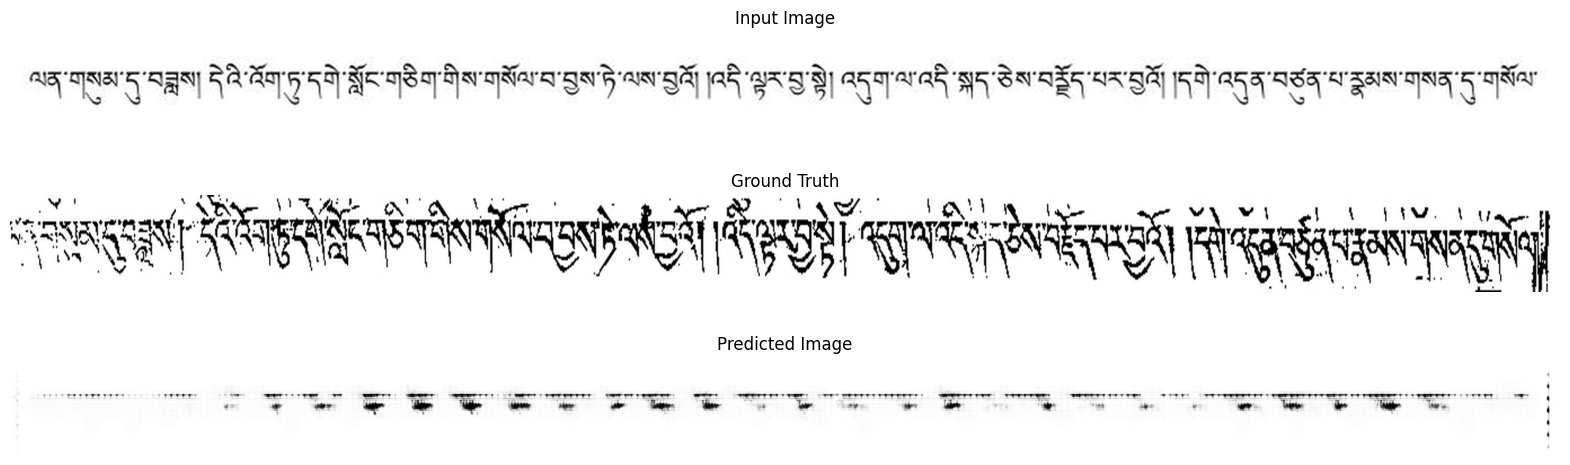

In [52]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Load the trained model
#model_path = '/path/to/model/dir/model_epoch_100.h5'
#generator = tf.keras.models.load_model(model_path, compile=False)

# Load the test dataset
test_source_folder = '/Resized_Text_Test_Images'  # Computer font images
test_target_folder = '/local_dir/Resized_Test_Images'  # Lhasa Kanjur font images

class FontDataset(tf.data.Dataset):
    def __new__(cls, source_dir, target_dir):
        source_images = sorted([os.path.join(source_dir, fname) for fname in os.listdir(source_dir) if not fname.startswith('.')])
        target_images = sorted([os.path.join(target_dir, fname) for fname in os.listdir(target_dir) if not fname.startswith('.')])
        
        def generator():
            for source_image_path, target_image_path in zip(source_images, target_images):
                source_image = np.array(Image.open(source_image_path).convert('L')) / 127.5 - 1
                target_image = np.array(Image.open(target_image_path).convert('L')) / 127.5 - 1
                yield source_image[..., np.newaxis], target_image[..., np.newaxis]

        dataset = tf.data.Dataset.from_generator(generator, output_signature=(
            tf.TensorSpec(shape=(256, 4096, 1), dtype=tf.float32),
            tf.TensorSpec(shape=(256, 4096, 1), dtype=tf.float32)
        ))
        return dataset.batch(1)

test_dataset = FontDataset(test_source_folder, test_target_folder)

# Get one example from the test dataset
test_example = next(iter(test_dataset))
test_source_image, test_target_image = test_example

# Generate prediction
prediction = generator(test_source_image, training=False)

# Function to display images
def display_images(input_image, target_image, predicted_image):
    plt.figure(figsize=(20, 6))

    display_list = [input_image[0], target_image[0], predicted_image[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(3, 1, i + 1)
        plt.title(title[i])
        plt.imshow(display_list[i] * 0.5 + 0.5, cmap='gray')
        plt.axis('off')
    plt.show()

# Display the images
display_images(test_source_image, test_target_image, prediction)
